In [17]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
def f(x):
    return 3*x**2 - 4*x + 5

In [21]:
f(3.0)

20.0

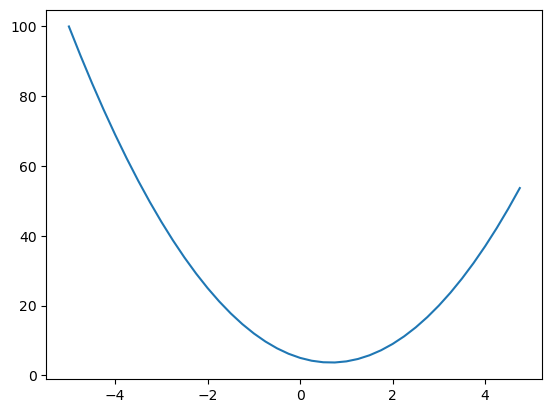

In [23]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [25]:
h=0.000001
x=2/3
(f(x+h) - f(x))/h

2.999378523327323e-06

In [27]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [29]:
h= 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [31]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"

    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')

    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0, label=L)

In [33]:
%pip install graphviz

In [34]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        label = f"{n.label} | data = {n.data}"
        dot.node(name=uid, label=label, shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

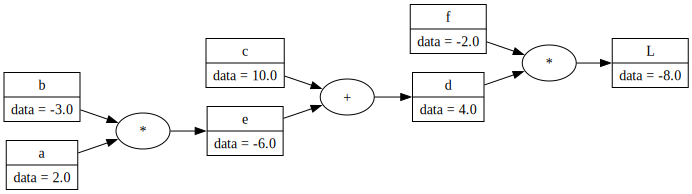

In [35]:
draw_dot(L)

In [37]:
import math

class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label

        self.grad = 4.0  
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [41]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-10.139136000000004


In [43]:
# Define your variables
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
f = Value(-2.0, label='f')

# Forward pass
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
L = d * f; L.label = 'L'

# Backward pass
L.backward()

# Gradient update (gradient ascent here; use -= for descent)
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# New forward pass
e = a * b
d = e + c
L = d * f

print(L.data)

-9.172992000000002


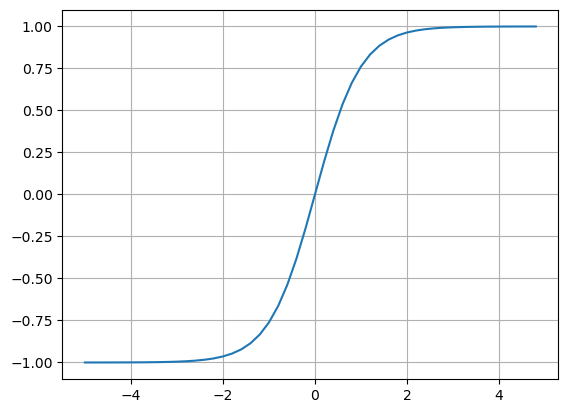

In [45]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [88]:
import math

class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(label={self.label}, data={self.data}, grad={self.grad})"
        
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def backward(self):
        # Topological sort of the graph
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0  
        for node in reversed(topo):
            node._backward()


In [90]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

print(o.data)  

0.7071067811865476


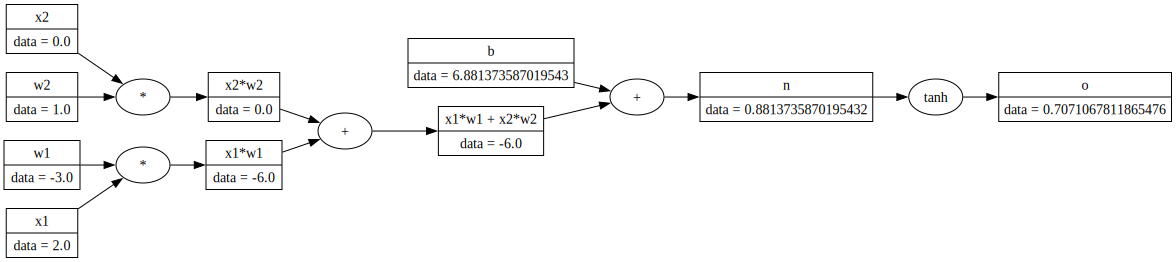

In [92]:
draw_dot(o)

In [94]:
o.backward()

In [96]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(label=x2, data=0.0, grad=0.4999999999999999),
 Value(label=w2, data=1.0, grad=0.0),
 Value(label=x2*w2, data=0.0, grad=0.4999999999999999),
 Value(label=x1, data=2.0, grad=-1.4999999999999996),
 Value(label=w1, data=-3.0, grad=0.9999999999999998),
 Value(label=x1*w1, data=-6.0, grad=0.4999999999999999),
 Value(label=x1*w1 + x2*w2, data=-6.0, grad=0.4999999999999999),
 Value(label=b, data=6.881373587019543, grad=0.4999999999999999),
 Value(label=n, data=0.8813735870195432, grad=0.4999999999999999),
 Value(label=o, data=0.7071067811865476, grad=1.0)]

In [98]:
o.grad = 1.0

In [100]:
o._backward()

In [104]:
n._backward()

In [106]:
b._backward()

In [108]:
x1w1x2w2._backward()

In [110]:
x2w2._backward()
x1w1._backward()

In [114]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [116]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [118]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [120]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [122]:
n.grad = 0.5

In [124]:
o.grad = 1.0

In [126]:
1 - o.data**2

0.4999999999999999

In [128]:
# o = tanh(n)
# do/dn = 1 - o**2

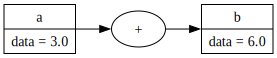

In [130]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

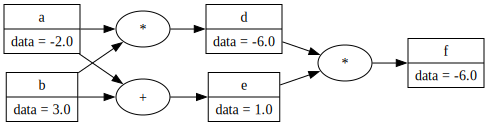

In [132]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

In [136]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float))
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): 
    return self * other

  def __truediv__(self, other): 
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): 
    return self + (-other)

  def __radd__(self, other): 
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad 
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [138]:
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return do

In [142]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

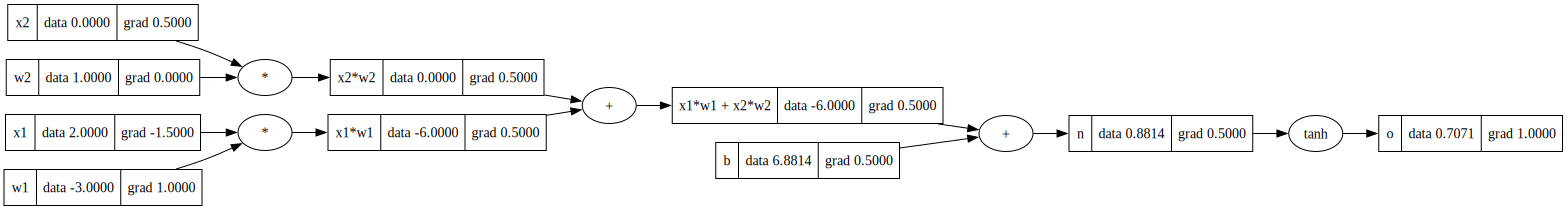

In [144]:
draw_dot(o)

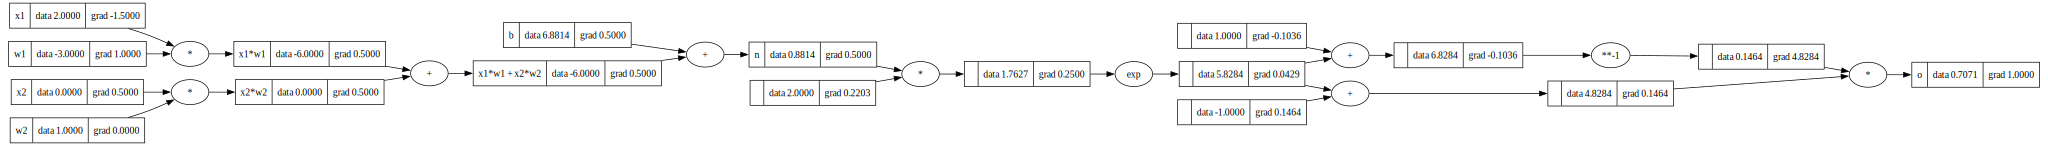

In [146]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'
o.backward()
draw_dot(o)

In [148]:
import torch

In [150]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [156]:
import random
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [158]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.6416938843929988)

In [160]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [162]:
for k in range(20):
  
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)
  

0 4.935758124759124
1 2.8120771395404205
2 1.2230598190842374
3 0.1022903468179821
4 0.0621893682262085
5 0.04806686044981353
6 0.039984777013414644
7 0.034535774227144864
8 0.030530346415215678
9 0.027424258337365028
10 0.024926369357371997
11 0.022863919609035634
12 0.02112652572062292
13 0.019639647973553526
14 0.018350749256314816
15 0.017221518078792027
16 0.016223232799928548
17 0.015333862061471085
18 0.01453617736421254
19 0.01381648255253881


In [164]:
ypred

[Value(data=0.9437435929160655),
 Value(data=-0.9379922214894979),
 Value(data=-0.9431355178178162),
 Value(data=0.9402240409120015)]